In [29]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

In [2]:
(train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.mnist.load_data()

In [3]:
train_images = [np.reshape(x, -1) for x in train_images]
test_images= [np.reshape(x, -1) for x in test_images]
train_images[0].shape

(784,)

In [4]:

def group_all_labels(data, num=100, minor=[]):
    # this function is to limit the number of labels that are used
    # it returns the indexes according the labels
    # data is an array of labels
    '''

    :param data: array of labels
    :param num: number required
    :param minor: list of minority indexes
    :return: array of labels indexes
    '''

    labels = np.unique(data)
    co_l = []
    if not minor:
        for l in labels:
            el_l = np.where(np.array(data) == l)
            co_l.append(el_l[0])

    else:
        for l in labels:
            if l in minor:
                el_l = np.where(np.array(data) == l)
                co_l.append((el_l[0])[:num])
            else:
                el_l = np.where(np.array(data) == l)
                co_l.append(el_l[0])
    return co_l

In [5]:
grouped_labels = group_all_labels(train_labels, 2000, [0, 1])
gr_data = []
gr_labels = [] 
for index, q in enumerate(grouped_labels):
    print('class {} : number of samples : {}'.format(index,len(q)))
    for r in q:
        gr_data.append(train_images[r])
        gr_labels.append(train_labels[r])

class 0 : number of samples : 2000
class 1 : number of samples : 2000
class 2 : number of samples : 5958
class 3 : number of samples : 6131
class 4 : number of samples : 5842
class 5 : number of samples : 5421
class 6 : number of samples : 5918
class 7 : number of samples : 6265
class 8 : number of samples : 5851
class 9 : number of samples : 5949


[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


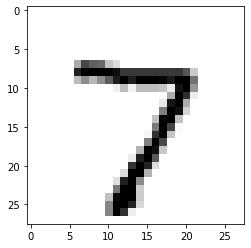

In [6]:
train_x = np.array(gr_data)
train_x = (train_x.astype(np.float32) / 255.0) 
test_x =  np.array(test_images)
test_images = (test_x.astype(np.float32)/255.0)
train_y = tf.keras.utils.to_categorical(gr_labels, num_classes=10, dtype='float32')
test_y = tf.keras.utils.to_categorical(test_labels, num_classes=10, dtype='float32')
print(test_y[0])
plt.imshow(np.reshape(test_x[0],(28,28)), cmap=plt.cm.gray_r, interpolation='nearest')

# Baseline RF with 1000 samples in class 0 and 1

In [7]:
from sklearn.ensemble import RandomForestClassifier
baseline_rf = RandomForestClassifier(max_depth=2, random_state=0)
baseline_rf.fit(train_x, gr_labels)
baseline_pred_y = baseline_rf.predict(test_x)
from sklearn.metrics import classification_report
print(classification_report(test_labels, baseline_pred_y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.56      0.82      0.67      1032
           3       0.38      0.78      0.51      1010
           4       0.73      0.73      0.73       982
           5       0.54      0.11      0.18       892
           6       0.63      0.89      0.74       958
           7       0.47      0.90      0.62      1028
           8       0.64      0.74      0.68       974
           9       0.71      0.55      0.62      1009

    accuracy                           0.55     10000
   macro avg       0.46      0.55      0.47     10000
weighted avg       0.46      0.55      0.47     10000



/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

#  VAE Model

In [8]:
import tensorflow.compat.v1  as tf
tf.disable_v2_behavior()
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np

mb_size = 64
z_dim = 100
X_dim = 784
y_dim = 10
h_dim = 128
lr = 1e-3


def plot(samples, sz, shape):
    fig = plt.figure(figsize=(sz, sz))
    gs = gridspec.GridSpec(sz, sz)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(shape, shape), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random.normal(shape=size, stddev=xavier_stddev)


# Q(z|X) 

X = tf.keras.Input(shape=(X_dim,))
c = tf.keras.Input(shape=(y_dim,))
z = tf.keras.Input(shape=(z_dim,))

Q_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X, c):
    inputs = tf.concat(axis=1, values=[X, c])
    h = tf.nn.relu(tf.matmul(inputs, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps


# P(X|z)

P_W1 = tf.Variable(xavier_init([z_dim + y_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z, c):
    inputs = tf.concat(axis=1, values=[z, c])
    h = tf.nn.relu(tf.matmul(inputs, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits

z_mu, z_logvar = Q(X, c)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample, c)

# Sampling from random z
X_samples, _ = P(z, c)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

# gradient step
solver = tf.compat.v1.train.AdamOptimizer().minimize(vae_loss)
sess = tf.compat.v1.Session ()
sess.run(
tf.compat.v1.global_variables_initializer())

if not os.path.exists('vae_mnist/'):
    os.makedirs('vae_mnist/')

i = 0

for it in range(100000):
    ind = np.random.choice(train_x.shape[0], mb_size)
    X_mb = np.array(train_x[ind])
    y_mb = np.array(train_y[ind])
    
    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb, c: y_mb})

    if it % 1000 == 0:
        print('Iter: {:0} Loss: {:0.4}'.format(it, loss))
        
        samples=[]
        for index in range(10):
            y = np.zeros([y_dim, y_dim])
            y[range(y_dim), index] = 1
            samples.extend(sess.run(X_samples,
                           feed_dict={z: np.random.randn(y_dim, z_dim), c: y}))

        fig = plot(samples, 10, 28)
        plt.savefig('vae_mnist/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)


Instructions for updating:
non-resource variables are not supported in the long term


2021-09-23 10:42:20.668167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 10:42:20.675328: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2021-09-23 10:42:20.676229: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-09-23 10:42:20.676854: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library

Iter: 0 Loss: 755.0
Iter: 1000 Loss: 148.2
Iter: 2000 Loss: 132.3
Iter: 3000 Loss: 115.4
Iter: 4000 Loss: 114.4
Iter: 5000 Loss: 112.4
Iter: 6000 Loss: 114.4
Iter: 7000 Loss: 108.2
Iter: 8000 Loss: 107.6
Iter: 9000 Loss: 110.9
Iter: 10000 Loss: 113.9
Iter: 11000 Loss: 105.3
Iter: 12000 Loss: 111.7
Iter: 13000 Loss: 103.8
Iter: 14000 Loss: 108.6
Iter: 15000 Loss: 106.7
Iter: 16000 Loss: 102.0
Iter: 17000 Loss: 109.4
Iter: 18000 Loss: 104.9
Iter: 19000 Loss: 107.8
Iter: 20000 Loss: 110.0
Iter: 21000 Loss: 110.5
Iter: 22000 Loss: 106.9
Iter: 23000 Loss: 109.0
Iter: 24000 Loss: 109.8
Iter: 25000 Loss: 107.9
Iter: 26000 Loss: 104.8
Iter: 27000 Loss: 107.5
Iter: 28000 Loss: 104.6
Iter: 29000 Loss: 107.4
Iter: 30000 Loss: 109.4
Iter: 31000 Loss: 110.7
Iter: 32000 Loss: 108.0
Iter: 33000 Loss: 107.8
Iter: 34000 Loss: 104.4
Iter: 35000 Loss: 108.6
Iter: 36000 Loss: 105.8
Iter: 37000 Loss: 104.0
Iter: 38000 Loss: 105.9
Iter: 39000 Loss: 107.4
Iter: 40000 Loss: 109.4
Iter: 41000 Loss: 109.6
Iter:

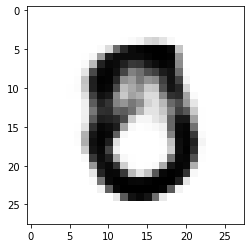

In [13]:
plt.imshow(np.reshape(samples[34],(28,28)), cmap=plt.cm.gray_r, interpolation='nearest')

In [10]:
samples = []
gen_labels =[]
for r in range(62):
    for index in range(2):
        gen_labels = gen_labels + [index]*64
        y = np.zeros([mb_size, y_dim])
        y[range(mb_size), index] = 1
        samples.extend(sess.run(X_samples,
                               feed_dict={z: np.random.randn(64, z_dim), c: y}))

gen_samples = np.array(samples)
gen_labels = np.array(gen_labels)
print(gen_samples.shape)
print(gen_labels.shape)
print(gen_labels[0])

(7936, 784)
(7936,)
0


# Adding and classifying with generated samples

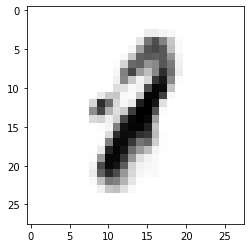

In [17]:
plt.imshow(np.reshape(gen_samples[65],(28,28)), cmap=plt.cm.gray_r, interpolation='nearest')
np.save('mnist_gen_data.npy', gen_samples)
np.save('mnist_gen_labels.npy', gen_labels)


In [27]:
X = np.concatenate([train_x, gen_samples])
Y = np.concatenate([np.reshape(gr_labels, -1), gen_labels])

aug_rf = RandomForestClassifier(max_depth=2, random_state=0)
aug_rf.fit(X, Y)
aug_pred_y = aug_rf.predict(test_x)
print(classification_report(test_labels, aug_pred_y))

              precision    recall  f1-score   support

           0       0.76      0.70      0.73       980
           1       0.53      0.28      0.36      1135
           2       0.59      0.71      0.64      1032
           3       0.45      0.69      0.54      1010
           4       0.76      0.51      0.61       982
           5       0.88      0.07      0.12       892
           6       0.67      0.78      0.72       958
           7       0.45      0.89      0.60      1028
           8       0.69      0.50      0.58       974
           9       0.58      0.62      0.60      1009

    accuracy                           0.58     10000
   macro avg       0.63      0.58      0.55     10000
weighted avg       0.63      0.58      0.55     10000



In [30]:
pd_aug = pd.DataFrame(classification_report(test_labels, aug_pred_y, output_dict=True))

In [32]:
pd_aug.transpose()

,precision,recall,f1-score,support
0,0.756608,0.701020,0.727754,980.0000
1,0.530405,0.276652,0.363636,1135.0000
2,0.585521,0.713178,0.643076,1032.0000
3,0.447066,0.694059,0.543832,1010.0000
4,0.758258,0.514257,0.612864,982.0000
5,0.878788,0.065022,0.121086,892.0000
6,0.666369,0.779749,0.718615,958.0000
7,0.450442,0.892996,0.598826,1028.0000
8,0.694286,0.498973,0.580645,974.0000
9,0.575646,0.618434,0.596273,1009.0000


In [33]:
pd_orig = pd.DataFrame(classification_report(test_labels, baseline_pred_y, output_dict=True))
pd_orig.transpose()

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,980.0000
1,0.000000,0.000000,0.000000,1135.0000
2,0.558998,0.821705,0.665359,1032.0000
3,0.376853,0.780198,0.508223,1010.0000
4,0.734694,0.733198,0.733945,982.0000
5,0.540230,0.105381,0.176360,892.0000
6,0.627941,0.891441,0.736842,958.0000
7,0.468464,0.895914,0.615230,1028.0000
8,0.635961,0.737166,0.682834,974.0000
9,0.706258,0.548067,0.617188,1009.0000


In [34]:
combined_pd = pd.merge(pd_orig.transpose(), pd_aug.transpose(), left_index=True, right_index=True)

In [35]:
combined_pd

,precision_x,recall_x,f1-score_x,support_x,precision_y,recall_y,f1-score_y,support_y
0,0.000000,0.000000,0.000000,980.0000,0.756608,0.701020,0.727754,980.0000
1,0.000000,0.000000,0.000000,1135.0000,0.530405,0.276652,0.363636,1135.0000
2,0.558998,0.821705,0.665359,1032.0000,0.585521,0.713178,0.643076,1032.0000
3,0.376853,0.780198,0.508223,1010.0000,0.447066,0.694059,0.543832,1010.0000
4,0.734694,0.733198,0.733945,982.0000,0.758258,0.514257,0.612864,982.0000
5,0.540230,0.105381,0.176360,892.0000,0.878788,0.065022,0.121086,892.0000
6,0.627941,0.891441,0.736842,958.0000,0.666369,0.779749,0.718615,958.0000
7,0.468464,0.895914,0.615230,1028.0000,0.450442,0.892996,0.598826,1028.0000
8,0.635961,0.737166,0.682834,974.0000,0.694286,0.498973,0.580645,974.0000
9,0.706258,0.548067,0.617188,1009.0000,0.575646,0.618434,0.596273,1009.0000
